In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category10
from bokeh.models import HoverTool
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator
import time
import joblib
import tensorflow as tf
import warnings
import os
warnings.filterwarnings('ignore')
print("DONE")

DONE


In [2]:
db_path = os.path.join("..", "data", "stock_data.db")
conn = sqlite3.connect(db_path)

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    device_name = gpus[0].name
    print(f"Using GPU: {device_name}")
else:
    device_name = "/CPU:0"
    print("GPU not found, using CPU")

Using GPU: /physical_device:GPU:0


In [3]:
tickers = {
    'MBSB': '1171.KL'
}

num_tickers = len(tickers)
sequence_length = 90
output_length = 1

In [4]:
all_stock_data = {}
for name, ticker in tickers.items():
    data = yf.download(ticker, period="5y", interval="1d")
    if not data.empty:
        data.to_sql(name, conn, if_exists='replace', index=True)
        all_stock_data[name] = data
        print(f"{name}: {len(data)} days - saved to database")
    else:
        try:
            data = pd.read_sql(f"SELECT * FROM {name}", conn, index_col='Date', parse_dates=['Date'])
            all_stock_data[name] = data
            print(f"{name}: No new data, loaded from database ({len(data)} days)")
        except:
            print(f"{name}: No data found and no database backup available")

print("DONE")

[*********************100%***********************]  1 of 1 completed

MBSB: 1223 days - saved to database
DONE


In [5]:
output_notebook()

p = figure(title="MBSB - Historical Closing Prices",
           x_axis_type='datetime',
           width=1300,
           height=600,
           tools="pan,wheel_zoom,box_zoom,reset,save")

colors = Category10[10]

for i, (name, data) in enumerate(all_stock_data.items()):
    color = colors[i % len(colors)]
    p.line(data.index, data['Close'], legend_label=name, line_width=2, color=color)

hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Price", "@y")], formatters={"@x": "datetime"})
p.add_tools(hover)

p.legend.click_policy="hide"
p.legend.location="top_left"
show(p)

Loading BokehJS ...

In [6]:
def calculate_features(data):
    df = data.copy()
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_50'] = EMAIndicator(df['Close'], window=50).ema_indicator()
    df['MACD'] = MACD(df['Close']).macd()
    df['RSI_14'] = RSIIndicator(df['Close'], window=14).rsi()
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    bb = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    df['ATR_14'] = (df['High'] - df['Low']).rolling(14).mean()
    obv = OnBalanceVolumeIndicator(df['Close'], df['Volume'])
    df['OBV'] = obv.on_balance_volume()
    return df

combined_data = []
for name, data in all_stock_data.items():
    df = pd.DataFrame({
        'Date': data.index,
        'Open': data['Open'].values.flatten(),
        'High': data['High'].values.flatten(),
        'Low': data['Low'].values.flatten(),
        'Close': data['Close'].values.flatten(),
        'Volume': data['Volume'].values.flatten(),
        'Stock': name
    })
    df = calculate_features(df)
    combined_data.append(df)

stock_order = list(all_stock_data.keys())
combined_df = pd.concat(combined_data, ignore_index=True)
combined_df['Stock'] = pd.Categorical(combined_df['Stock'], categories=stock_order, ordered=True)
combined_df = combined_df.sort_values(['Date', 'Stock']).reset_index(drop=True)

In [7]:
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_50', 
                   'MACD', 'RSI_14', 'Momentum_10', 'BB_upper', 'BB_lower', 'ATR_14', 'OBV']
n_features = len(feature_columns)
combined_df_clean = combined_df[feature_columns].dropna()

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
all_features = combined_df_clean[feature_columns].values
all_targets = combined_df_clean[['Close']].values

scaler_features.fit(all_features)
scaler_target.fit(all_targets)
scaled_features = scaler_features.transform(all_features)
scaled_targets = scaler_target.transform(all_targets)

In [8]:
def create_sequences(features, targets, seq_length):
    X, y = [], []
    for i in range(seq_length, len(features), num_tickers):
        X.append(features[i-seq_length:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_targets, sequence_length)
print(f"X shape: {X.shape} (samples, time_steps, features)")
print(f"y shape: {y.shape} (samples, 1)")

X shape: (1084, 90, 14) (samples, time_steps, features)
y shape: (1084, 1) (samples, 1)


In [9]:
split_ratio = 0.80
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 867
Testing samples: 217


In [10]:
models = tf.keras.models
layers = tf.keras.layers
callbacks = tf.keras.callbacks

model = models.Sequential([
    layers.LSTM(units=100, return_sequences=True, input_shape=(sequence_length, n_features)),
    layers.Dropout(0.3),
    
    layers.LSTM(units=100, return_sequences=True),
    layers.Dropout(0.3),
    
    layers.LSTM(units=80, return_sequences=True),
    layers.Dropout(0.2),
    
    layers.LSTM(units=80, return_sequences=False),
    layers.Dropout(0.2),
    
    layers.Dense(units=50, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(units=output_length)
])

model.compile(optimizer='adam', loss='mean_squared_error')
print("Model built successfully!")
model.summary()

2025-10-23 18:33:30.908883: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-10-23 18:33:30.908911: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-23 18:33:30.908915: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-23 18:33:30.908943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-23 18:33:30.908952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 90, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 90, 80)         │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         4,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,941 (937.27 KB)

 Trainable params: 239,941 (937.27 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
print("Phase1: Training model without early stopping")
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

end_time = time.time()
total_time = end_time - start_time

print("Training complete")
print(f"Total training time: {total_time:.2f} seconds")

Phase1: Training model without early stopping
Epoch 1/50


2025-10-23 18:33:31.583370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.0268 - val_loss: 0.0071
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0103 - val_loss: 0.0027
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0111 - val_loss: 0.0019
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0096 - val_loss: 0.0134
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0152 - val_loss: 0.0083
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0110 - val_loss: 0.0088
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0092 - val_loss: 0.0014
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0084 - val_loss: 0.0019
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0095 - val_loss: 0.0016
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0221 - val_

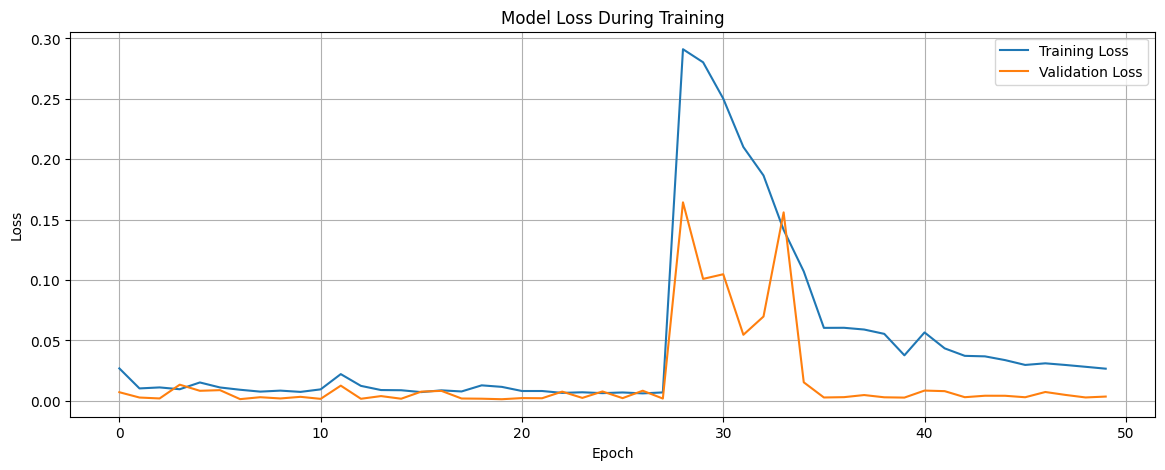

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print("Phase2: Training model with early stopping")
start_time = time.time()

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

end_time = time.time()
total_time = end_time - start_time

print("Training complete!")
print(f"Total training time: {total_time:.2f} seconds")

Phase2: Training model with early stopping
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0262 - val_loss: 0.0044
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0282 - val_loss: 0.0034
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0300 - val_loss: 0.0028
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0235 - val_loss: 0.0028
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0229 - val_loss: 0.0052
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0205 - val_loss: 0.0034
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0207 - val_loss: 0.0035
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0204 - val_loss: 0.0033
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0203 - val_loss: 0.0035
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0211 - val_loss: 0.0032
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0206 - val_loss: 0.0036
Epoch 12/

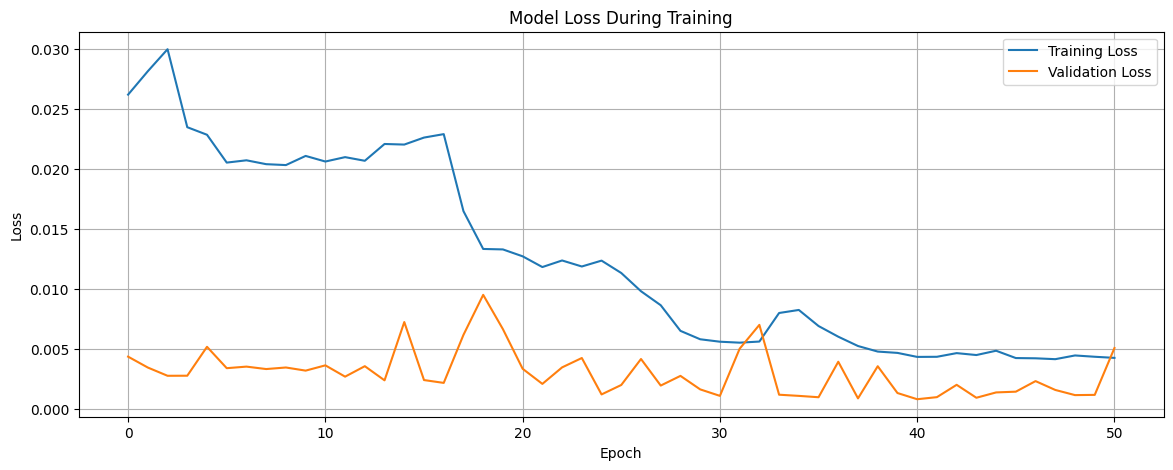

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model_path = os.path.join("models", "mbsb_model.h5")
model.save(model_path)
print("Model saved")

scaler_features_path = os.path.join("scalers", "mbsb_scaler_features.pkl")
scaler_target_path = os.path.join("scalers", "mbsb_scaler_target.pkl")
joblib.dump(scaler_features, scaler_features_path)
joblib.dump(scaler_target, scaler_target_path)
print("Scaler saved")

Model saved
Scaler saved


In [16]:
print("Making predictions on test set...")
y_pred_scaled = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_actual = scaler_target.inverse_transform(y_test)

Making predictions on test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [17]:
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print("\n=== Model Performance Metrics ===")
print(f"RMSE: RM {rmse:.4f}")
print(f"MAE: RM {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


=== Model Performance Metrics ===
RMSE: RM 0.0128
MAE: RM 0.0090
R² Score: 0.6823
MAPE: 1.31%


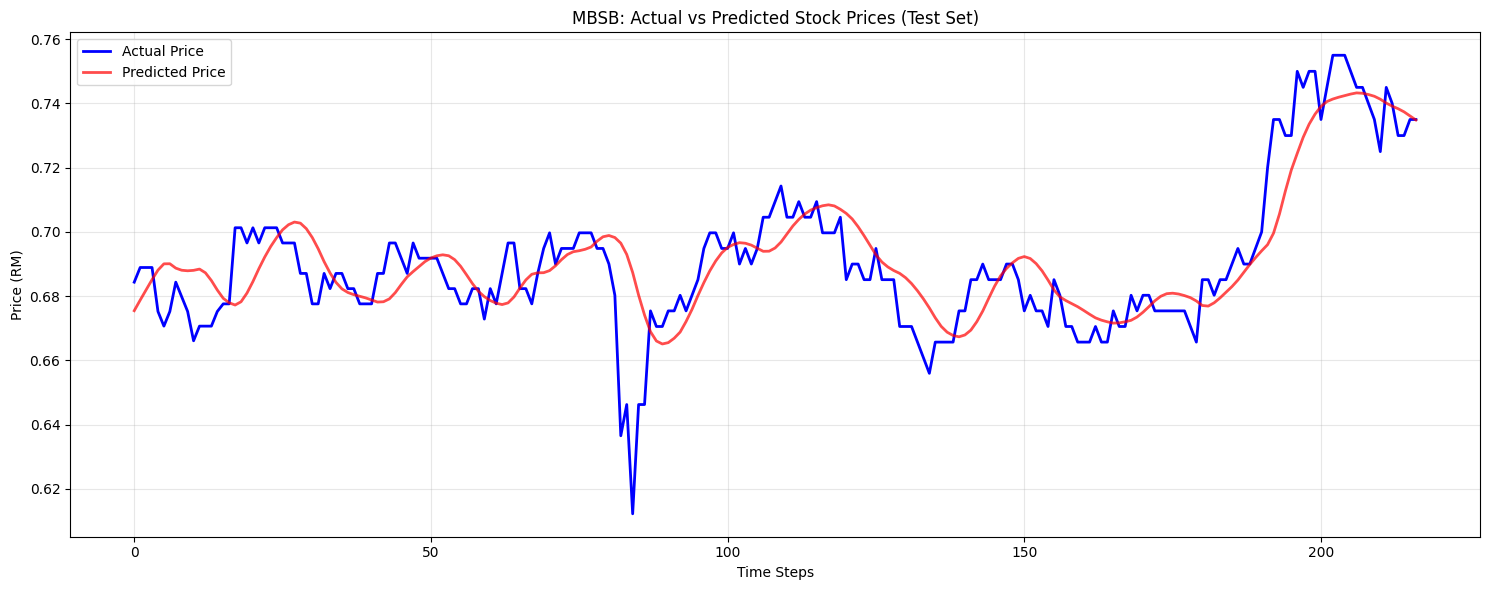

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Actual Price', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Price', color='red', linewidth=2, alpha=0.7)
plt.title('MBSB: Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price (RM)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
def predict_future(model, last_seq, scaler_features, scaler_target, n_days=30):
    """Predict multiple days into the future"""
    predictions = []
    current_seq = last_seq.copy()
    
    for _ in range(n_days):
        # Predict next day
        pred_scaled = model.predict(current_seq, verbose=0)
        pred_price = scaler_target.inverse_transform(pred_scaled)[0][0]
        predictions.append(pred_price)
        
        # Update sequence: remove first day, add prediction
        # We need to create a full feature vector for the prediction
        # For simplicity, we'll duplicate the last feature set and update Close
        new_features = current_seq[0, -1, :].copy()
        
        # Update the Close price in the feature vector
        close_idx = feature_columns.index('Close')
        new_features[close_idx] = pred_scaled[0][0]  # scaled value
        
        # Reshape and append
        new_features = new_features.reshape(1, 1, n_features)
        current_seq = np.concatenate([current_seq[:, 1:, :], new_features], axis=1)
    
    return predictions

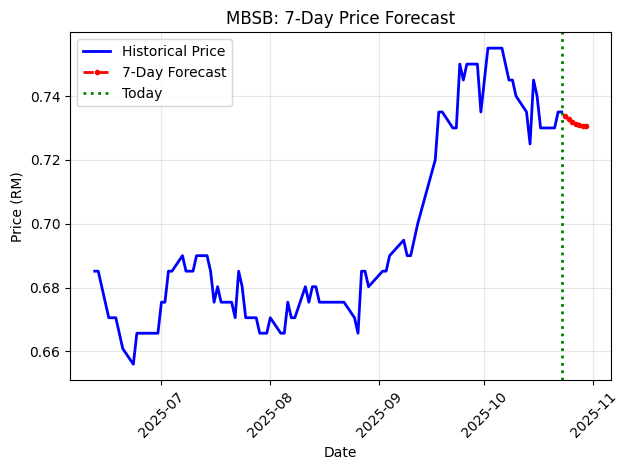

In [20]:
forecast_days = 7
last_seq = scaled_features[-sequence_length:].reshape(1, sequence_length, n_features)
future_prices = predict_future(model, last_seq, scaler_features, scaler_target, forecast_days)
last_date = combined_df_clean['Date'].iloc[-1] if 'Date' in combined_df_clean.columns else combined_df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='D')
historical_data = combined_df_clean['Close'].tail(90)
historical_dates = combined_df['Date'].tail(90) if 'Date' in combined_df.columns else range(len(historical_data))

plt.plot(historical_dates, historical_data.values, 
         label='Historical Price', color='blue', linewidth=2)
plt.plot(future_dates, future_prices, 
         label=f'{forecast_days}-Day Forecast', color='red', 
         linewidth=2, linestyle='--', marker='o', markersize=3)

plt.axvline(x=last_date, color='green', linestyle=':', linewidth=2, label='Today')
plt.title(f'MBSB: {forecast_days}-Day Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (RM)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [21]:
future_prices

[0.7336732, 0.73268265, 0.7318967, 0.7313123, 0.7309093, 0.7306579, 0.7305253]